In [ ]:
# ==============================
# 📆 LSTM Price + Direction Prediction for AAPL
# ==============================
# 1. Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
!pip install keras_tuner
import keras_tuner as kt
!pip install ta
import ta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=b1b62d0f9248e7223fc21ca0f05296c302548327fc30916cda2341a6f3e9c1e8
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [ ]:
# 2. Load and Feature Engineering
stock_data = yf.download('AAPL', start='2015-01-01', end='2023-12-31')
stock_data['RSI'] = ta.momentum.RSIIndicator(close=stock_data['Close'].squeeze()).rsi()
stock_data['MACD'] = ta.trend.MACD(close=stock_data['Close'].squeeze()).macd()
stock_data['SMA_20'] = ta.trend.SMAIndicator(close=stock_data['Close'].squeeze(), window=20).sma_indicator()
stock_data['Close_lag_1'] = stock_data['Close'].shift(1)
stock_data['Return_1'] = stock_data['Close'].pct_change()
stock_data['Direction'] = np.where(stock_data['Close'].shift(-1) > stock_data['Close'], 1, 0)
stock_data.dropna(inplace=True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
# 3. Preprocessing
features = ['Close', 'RSI', 'MACD', 'SMA_20', 'Return_1', 'Close_lag_1']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(stock_data[features])
close_index = features.index('Close')
y_scaled = scaled_data[:, close_index]

In [ ]:
# 4. Sequence Preparation
def create_dataset(data, labels, time_step=100):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:i + time_step])
        y.append(labels[i + time_step])
    return np.array(X), np.array(y)

time_step = 100
X_price, y_price = create_dataset(scaled_data, y_scaled, time_step)
X_dir, y_dir = create_dataset(scaled_data, stock_data['Direction'].values, time_step)

In [ ]:
# 5. Train-Test Split
split = int(len(X_price) * 0.65)
X_train_price, X_test_price = X_price[:split], X_price[split:]
y_train_price, y_test_price = y_price[:split], y_price[split:]
X_train_dir, X_test_dir = X_dir[:split], X_dir[split:]
y_train_dir, y_test_dir = y_dir[:split], y_dir[split:]

In [ ]:
# 6. Hyperparameter Tuning for Price Prediction

def build_price_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units1', 32, 128, step=32), return_sequences=True, input_shape=(time_step, X_price.shape[2])))
    model.add(Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units2', 32, 128, step=32)))
    model.add(Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

tuner_price = kt.RandomSearch(build_price_model, objective='val_loss', max_trials=5, overwrite=True, directory='tuner', project_name='price')
tuner_price.search(X_train_price, y_train_price, epochs=10, validation_data=(X_test_price, y_test_price), callbacks=[EarlyStopping(patience=5)])
model_price = tuner_price.get_best_models(num_models=1)[0]

Trial 5 Complete [00h 01m 52s]
val_loss: 0.0008848516154102981

Best val_loss So Far: 0.0006876084953546524
Total elapsed time: 00h 09m 24s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# 7. Inverse Scaling Helper
def inverse_close(pred, feature_index, reference_shape):
    pad = np.zeros((len(pred), reference_shape))
    pad[:, feature_index] = pred.flatten()
    return scaler.inverse_transform(pad)[:, feature_index]

train_pred_price = model_price.predict(X_train_price)
test_pred_price = model_price.predict(X_test_price)
train_inv = inverse_close(train_pred_price, close_index, len(features))
test_inv = inverse_close(test_pred_price, close_index, len(features))
y_train_inv = inverse_close(y_train_price.reshape(-1, 1), close_index, len(features))
y_test_inv = inverse_close(y_test_price.reshape(-1, 1), close_index, len(features))

44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step


In [ ]:
# 8. Price Metrics
print("=== Price Prediction Metrics ===")
print(f"MSE:  {mean_squared_error(y_test_inv, test_inv):.4f}")
print(f"MAE:  {mean_absolute_error(y_test_inv, test_inv):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_inv, test_inv)):.4f}")
print(f"R2:   {r2_score(y_test_inv, test_inv):.4f}")

=== Price Prediction Metrics ===
MSE:  21.3607
MAE:  3.6185
RMSE: 4.6218
R2:   0.9470


In [ ]:
# 9. Hyperparameter Tuning for Direction Classifier

def build_dir_model(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=hp.Int('units1', 32, 128, step=32), return_sequences=True), input_shape=(time_step, X_dir.shape[2])))
    model.add(Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.1)))
    model.add(Bidirectional(LSTM(units=hp.Int('units2', 32, 128, step=32))))
    model.add(Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

tuner_dir = kt.RandomSearch(build_dir_model, objective='val_accuracy', max_trials=5, overwrite=True, directory='tuner', project_name='direction')
tuner_dir.search(X_train_dir, y_train_dir, epochs=10, validation_data=(X_test_dir, y_test_dir), callbacks=[EarlyStopping(patience=5)])
model_dir = tuner_dir.get_best_models(num_models=1)[0]

Trial 5 Complete [00h 01m 42s]
val_accuracy: 0.5206942558288574

Best val_accuracy So Far: 0.5233644843101501
Total elapsed time: 00h 11m 34s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# 10. Classification Metrics
pred_dir_probs = model_dir.predict(X_test_dir)
pred_dir_binary = (pred_dir_probs > 0.5).astype(int)

print("\n=== Direction Classification Metrics ===")
print(f"Accuracy:  {accuracy_score(y_test_dir, pred_dir_binary):.4f}")
print(f"Precision: {precision_score(y_test_dir, pred_dir_binary):.4f}")
print(f"Recall:    {recall_score(y_test_dir, pred_dir_binary):.4f}")
print(f"F1 Score:  {f1_score(y_test_dir, pred_dir_binary):.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step

=== Direction Classification Metrics ===
Accuracy:  0.5234
Precision: 0.5280
Recall:    0.7974
F1 Score:  0.6353



=== Final Trading Signal ===
Last Real Price:     192.42
Predicted Price:     191.96
Direction Predicted: Down
RSI:                 51.12
Suggested Action:    Hold


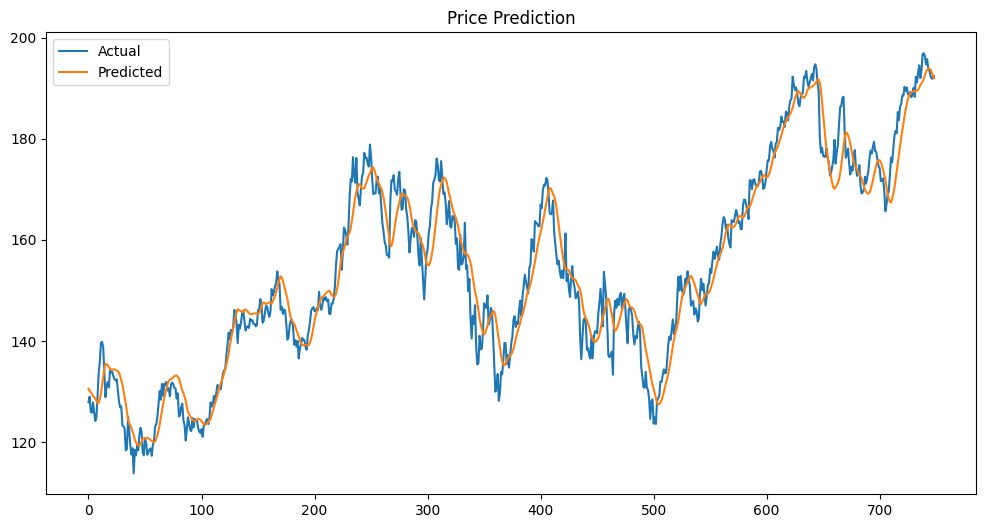

In [ ]:
# 11. Trading Signal
last_rsi = stock_data['RSI'].iloc[-1]
last_pred_price = test_inv[-1]
last_real_price = y_test_inv[-1]
predicted_trend = "Up" if last_pred_price > last_real_price else "Down"

def trading_signal(direction, rsi):
    if direction == "Up" and rsi < 30:
        return "Buy"
    elif direction == "Down" and rsi > 70:
        return "Sell"
    return "Hold"

signal = trading_signal(predicted_trend, last_rsi)

print("\n=== Final Trading Signal ===")
print(f"Last Real Price:     {last_real_price:.2f}")
print(f"Predicted Price:     {last_pred_price:.2f}")
print(f"Direction Predicted: {predicted_trend}")
print(f"RSI:                 {last_rsi:.2f}")
print(f"Suggested Action:    {signal}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(test_inv, label='Predicted')
plt.legend()
plt.title("Price Prediction")
plt.show()

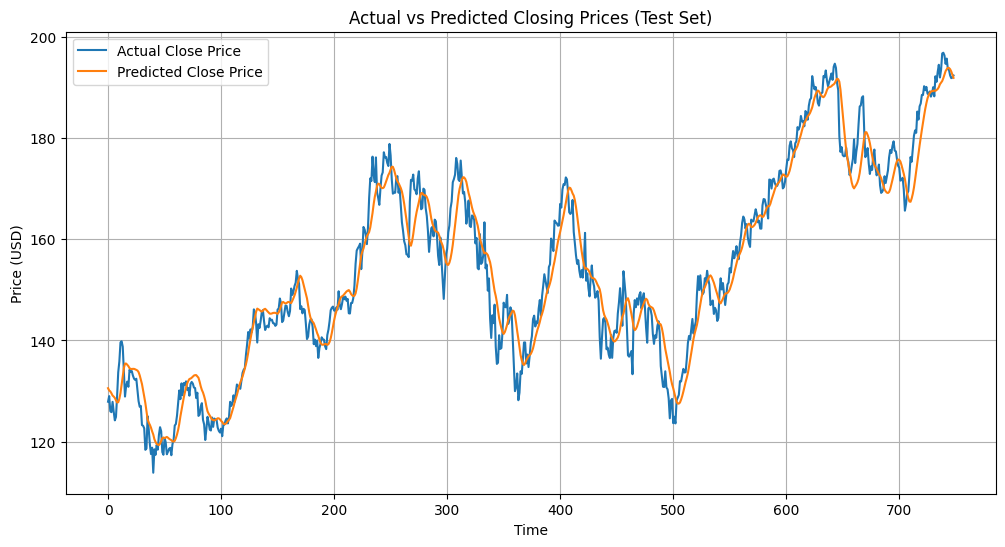

In [ ]:
#ACTUAL VS PREDICTED CLOSING PRICES
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Close Price')
plt.plot(test_inv, label='Predicted Close Price')
plt.title("Actual vs Predicted Closing Prices (Test Set)")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

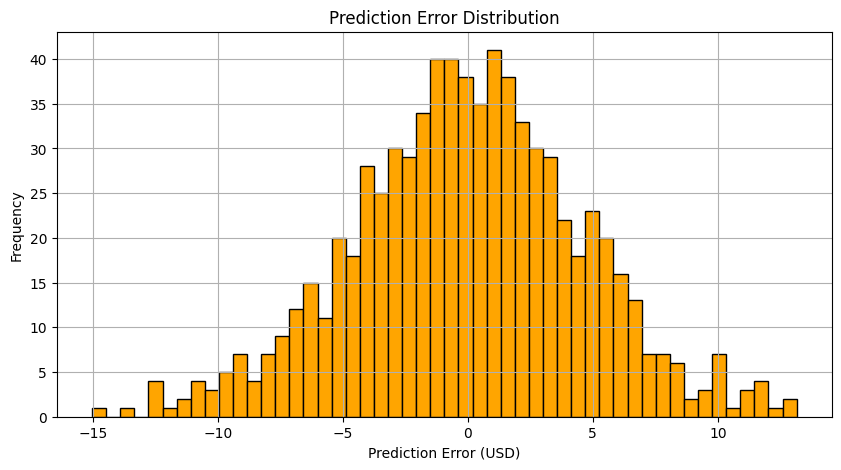

In [ ]:
#PREDICTION ERROR DISTRIBUTION (PRICE MODEL DISTRIBUTION)
errors = y_test_inv - test_inv
plt.figure(figsize=(10, 5))
plt.hist(errors, bins=50, color='orange', edgecolor='black')
plt.title("Prediction Error Distribution")
plt.xlabel("Prediction Error (USD)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

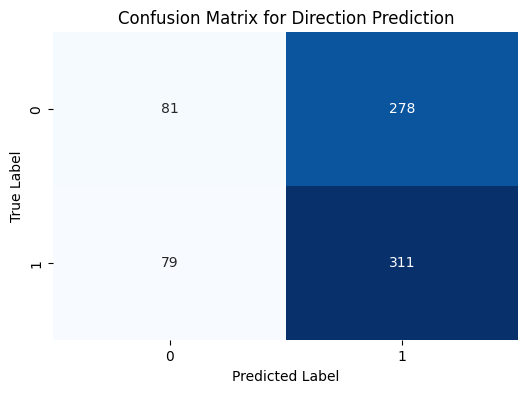

In [ ]:
#DIRECT CLASSIFICATION (CONFUSION MATRIX)
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_dir, pred_dir_binary)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix for Direction Prediction")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

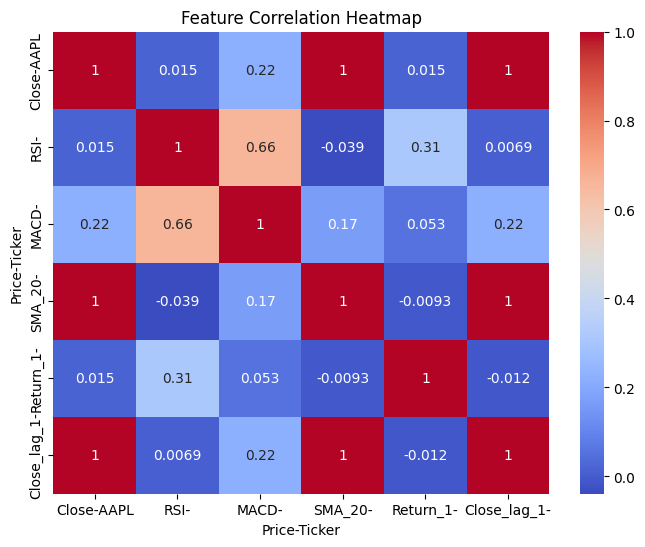

In [ ]:
#FEATURE IMPORTANCE CORRELATION MAP
plt.figure(figsize=(8, 6))
sns.heatmap(stock_data[features].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4960 - loss: 0.6935 - val_accuracy: 0.5207 - val_loss: 0.6982
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5118 - loss: 0.6930 - val_accuracy: 0.5207 - val_loss: 0.6960
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5217 - loss: 0.6922 - val_accuracy: 0.5207 - val_loss: 0.6952
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5252 - loss: 0.6944 - val_accuracy: 0.5207 - val_loss: 0.6932
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 988ms/step - accuracy: 0.5259 - loss: 0.6909 - val_accuracy: 0.5207 - val_loss: 0.6962
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 919ms/step - accuracy: 0.5081 - loss: 0.6949 - val_accuracy: 0.5207 - val_loss: 0.7156
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5490 - loss: 0.6910 - val_accuracy: 0.4780 - val_loss: 0.6963
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5282 - loss: 0.6915 - val_accuracy: 0.5207 - val

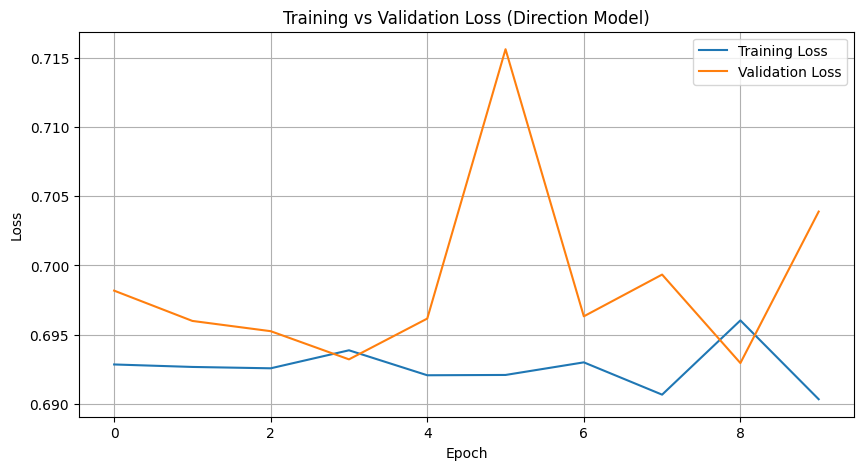

In [ ]:
#TRAINING VS VALIDATION LOSS CURVES
history = model_dir.fit(X_train_dir, y_train_dir,
                        validation_data=(X_test_dir, y_test_dir),
                        epochs=10, batch_size=64, verbose=1,
                        callbacks=[EarlyStopping(patience=5)])

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss (Direction Model)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

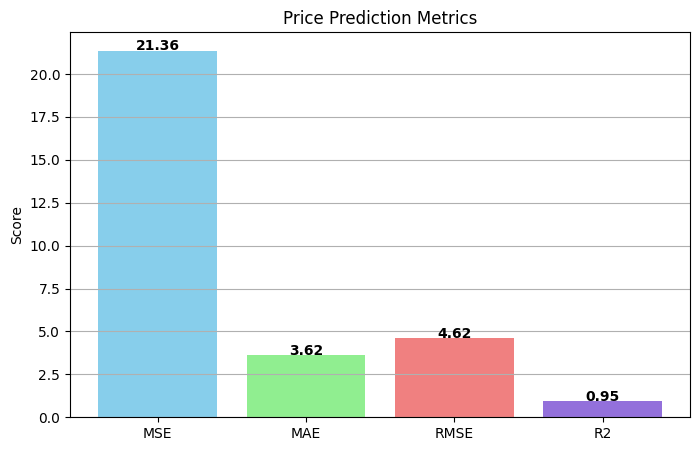

In [ ]:
#PRICE PREDICTION METRICS BAR PLOT
# Price Prediction Metrics
mse = mean_squared_error(y_test_inv, test_inv)
mae = mean_absolute_error(y_test_inv, test_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, test_inv)

metrics_price = {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R2': r2}

plt.figure(figsize=(8, 5))
plt.bar(metrics_price.keys(), metrics_price.values(), color=['skyblue', 'lightgreen', 'lightcoral', 'mediumpurple'])
plt.title("Price Prediction Metrics")
plt.ylabel("Score")
for i, v in enumerate(metrics_price.values()):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')
plt.grid(True, axis='y')
plt.show()

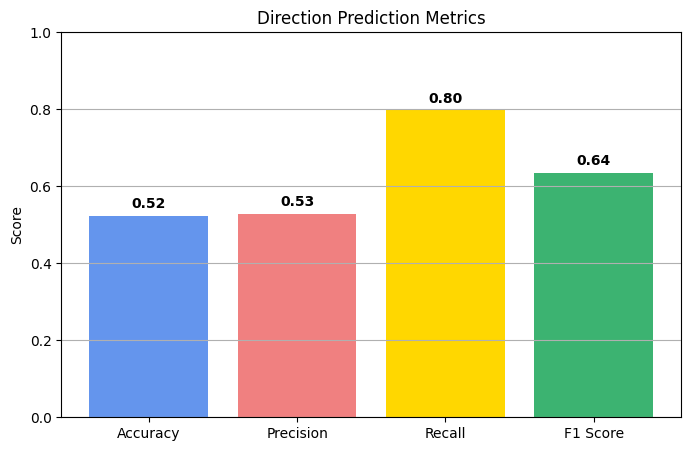

In [ ]:
#DIRECTION PREDICTION METRICS BAR PLOT
# Direction Prediction Metrics
acc = accuracy_score(y_test_dir, pred_dir_binary)
prec = precision_score(y_test_dir, pred_dir_binary)
rec = recall_score(y_test_dir, pred_dir_binary)
f1 = f1_score(y_test_dir, pred_dir_binary)

metrics_dir = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1}

plt.figure(figsize=(8, 5))
plt.bar(metrics_dir.keys(), metrics_dir.values(), color=['cornflowerblue', 'lightcoral', 'gold', 'mediumseagreen'])
plt.title("Direction Prediction Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)  # because these are percentages
for i, v in enumerate(metrics_dir.values()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.grid(True, axis='y')
plt.show()